In [1]:
import torch
import numpy as np
import os
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm
from torchsummary import summary
#from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
#import torchxrayvision as xrv

### read data

In [2]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

### 重写数据集类

In [3]:
class CovidCTDataset(Dataset):
    def __init__(self,root_dir, txt_COVID, txt_NonCOVID, transform=None):
        self.root_dir = root_dir
        self.txt_path = [txt_NonCOVID,txt_COVID]
        self.classes = ['CT_NonCOVID', 'CT_COVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = self.img_list[idx][1]
        #one-hot code
        ar = np.array(label)
        #ar = to_categorical(ar,num_classes=2)
        ar = torch.from_numpy(ar.astype(np.int))

        return image,ar

### 数据增强

In [4]:
txt_COVID = 'Data-split/COVID/trainCT_COVID.txt'
txt_NonCOVID = 'Data-split/NonCOVID/trainCT_NonCOVID.txt'
txt_path = [txt_COVID,txt_NonCOVID]
root_dir = 'Images-processed'
classes = ['CT_NonCOVID', 'CT_COVID']
img_list = []
for c in range(2):
    cls_list = [[os.path.join(root_dir,classes[c],item), c] for item in read_txt(txt_path[c])]
    img_list += cls_list


In [5]:
#三通道标准化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
##训练集增强
train_transform = transforms.Compose([
        transforms.Resize(256),#之后要进行裁剪
        transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
##验证集、测试集增强
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [6]:
batchsize = 16

In [7]:
traindataset = CovidCTDataset(root_dir,
                              txt_COVID= 'Data-split/COVID/trainCT_COVID.txt',
                             txt_NonCOVID= 'Data-split/NonCOVID/trainCT_NonCOVID.txt',
                             transform = train_transform)
valdataset = CovidCTDataset(root_dir,
                              txt_COVID= 'Data-split/COVID/valCT_COVID.txt',
                             txt_NonCOVID= 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                             transform = val_transform)
testdataset = CovidCTDataset(root_dir,
                              txt_COVID= 'Data-split/COVID/testCT_COVID.txt',
                             txt_NonCOVID= 'Data-split/NonCOVID/testCT_NonCOVID.txt',
                             transform = val_transform)

train_dataloder = DataLoader(traindataset,batchsize,shuffle=True)
val_dataloder = DataLoader(valdataset,batchsize,shuffle=False)
test_dataloder = DataLoader(testdataset,batchsize,shuffle=False)

## 模型搭建

### densenet121

In [8]:
densenetmodule = models.densenet121(pretrained=True)
#densenetmodule = models.densenet121(pretrained=False)

In [9]:
#模型1
densenetmodule.classifier = nn.Linear(1024,2)
model = densenetmodule.cuda()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [10]:
#模型2
model = nn.Sequential(densenetmodule)
#model.add_module('finalpool',nn.AvgPool2d())
model.add_module('finalfc1',nn.Linear(1000,512))
model.add_module('finalacti1',nn.ReLU())
model.add_module('dropout',nn.Dropout())
model.add_module('finalfc2',nn.Linear(512,2))
model.add_module('finalacti2',nn.Softmax())
model.cuda()

#summary(model,(3,224,224))

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

In [11]:
#加载模型参数
params = torch.load('densenetpre_100.pkl')
model.load_state_dict(params)

<All keys matched successfully>

### resnet

In [8]:
resnetmodule = models.resnet50(pretrained=False)
resnetmodule.fc = nn.Linear(2048,2)
model = resnetmodule.cuda()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#加载模型参数
params = torch.load('resnet_100.pkl')
model.load_state_dict(params)

### 训练

In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criteria = nn.CrossEntropyLoss()
#?
#classify = nn.Linear(1000,2).cuda()

In [10]:
#densenetmodule.train()
epoches = 100
train_losslist = []
train_acclist = []
val_losslist = []
val_acclist = []
for epoch in range(epoches):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    model.train()
    for img,label in tqdm(train_dataloder):
        img = img.cuda()
        label = label.cuda()

        out = model(img)
        #res = classify(out)
        #res = torch.sigmoid(res)

        loss = criteria(out,label.long())
        train_loss += float(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = out.argmax(1).cpu()
        true = label.cpu()
        #break
        acc_num = np.argwhere(pred==true).shape[1]
        train_acc += acc_num
        cc = acc_num/len(train_dataloder)
    #validation
    model.eval()
    with torch.no_grad():
        for img,label in tqdm(val_dataloder):
            img = img.cuda()
            label = label.cuda()

            out = model(img)
            #res = classify(out)
            #res = torch.sigmoid(res)

            loss = criteria(out,label.long())
            val_loss += float(loss)

            pred = out.argmax(1).cpu()
            true = label.cpu()

            #pred_list = np.r_[pred_list,pred.numpy()]
            #true_list = np.r_[true_list,true.numpy()]
            #break
            acc_num = np.argwhere(pred==true).shape[1]
            val_acc += acc_num
            #cc = acc_num/len(train_dataloder)
            #print('{}/{}'.format(num,len(test_dataloder.dataset)))
    print('epoch:',epoch)
    print('train_acc:',train_acc/len(train_dataloder.dataset))
    print('train_loss:',train_loss/len(train_dataloder))
    print('val_acc:',val_acc/len(val_dataloder.dataset))
    print('val_loss:',val_loss/len(val_dataloder))
    train_losslist.append(train_loss/len(train_dataloder))
    train_acclist.append(train_acc/len(train_dataloder.dataset))
    val_losslist.append(val_loss/len(val_dataloder))
    val_acclist.append(val_acc/len(val_dataloder.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.71it/s]


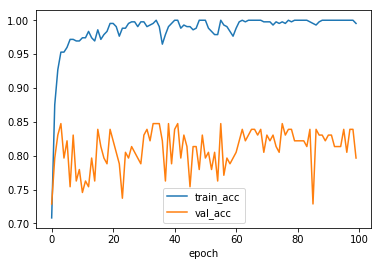

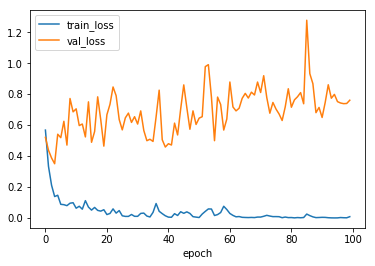

In [12]:
plt.figure()
plt.plot(train_acclist)
plt.plot(val_acclist)
plt.legend(['train_acc','val_acc'])
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(train_losslist)
plt.plot(val_losslist)
plt.legend(['train_loss','val_loss'])
plt.xlabel('epoch')
plt.show()

In [18]:
torch.save(model.state_dict(),'densenet_100.pkl')

### 测试

In [13]:
#densenetmodule.eval()
test_loss = 0
acc = 0
test_acc = 0
pred_prop = np.array([])
pred_list = np.array([])
true_list = np.array([])
num = 0
model.eval()
with torch.no_grad():
    for img,label in tqdm(test_dataloder):
        img = img.cuda()
        label = label.cuda()

        out = model(img)
        #res = classify(out)
        #res = torch.sigmoid(res)

        loss = criteria(out,label.long())
        test_loss += float(loss)

        
        pred_prop = np.r_[pred_prop,out[:,0].cpu().numpy()]#求ROC
        
        pred = out.argmax(1).cpu()
        true = label.cpu()
        
        pred_list = np.r_[pred_list,pred.numpy()]
        true_list = np.r_[true_list,true.numpy()]
        #break
        acc_num = np.argwhere(pred==true).shape[1]
        test_acc += acc_num
        #cc = acc_num/len(train_dataloder)
        #print('{}/{}'.format(num,len(test_dataloder.dataset)))
        #num += len(img)
    print('acc:',test_acc/len(test_dataloder.dataset))
    print('loss:',test_loss/len(test_dataloder))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]

acc: 0.8275862068965517
loss: 0.8977257483280622


In [15]:
cm

array([[60, 38],
       [18, 87]], dtype=int64)

accu 0.8275862068965517
recall: 0.8761904761904762
F1: 0.8401826484018265


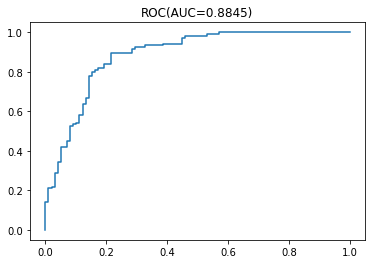

In [14]:
cm = confusion_matrix(true_list,pred_list)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
accu = (TP+TN)/len(pred_list)
prec = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*prec*recall/(prec+recall)
print('accu',accu)
print('recall:',recall)
print('F1:',F1)

fpr,tpr,threshold = roc_curve(true_list,pred_prop)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(tpr,fpr)
plt.title('ROC(AUC=%.4f)'%(1-roc_auc))
#plt.savefig('densenetpre_100.jpg')
plt.show()